In [1]:
!pip install tf-keras-vis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 1.9 MB/s eta 0:00:00


**Tensorboard logs**

In [2]:
# Load the extension and start TensorBoard -Not working on Kaggle

%load_ext tensorboard
%tensorboard --logdir /kaggle/input/model-training/logs

<IPython.core.display.Javascript object>

**Grad-CAM Heatmap**

In [3]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils.scores import CategoricalScore

2025-09-27 19:26:02.955221: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1759001162.976643      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1759001162.983158      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Load Model
model_path = "/kaggle/input/model-training/best_model.keras"
custom_model = load_model(model_path)

print(custom_model.summary())

I0000 00:00:1759001166.598185      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1759001166.598964      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_20 (Conv2D)              │ (None, 32, 32, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 43)             │        22,059 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,559,779 (25.02 MB)

 Trainable params: 2,186,123 (8.34 MB)

 Non-trainable params: 1,408 (5.50 KB)

 Optimizer params: 4,372,248 (16.68 MB)

None


In [5]:
# Load test data
with open("/kaggle/input/data-preprocessing/x_test.pkl", "rb") as f:
    x_test = pickle.load(f)
with open("/kaggle/input/data-preprocessing/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (113670, 32, 32, 1)
y_test shape: (113670, 43)


I0000 00:00:1759001172.063125      19 cuda_dnn.cc:529] Loaded cuDNN version 90300


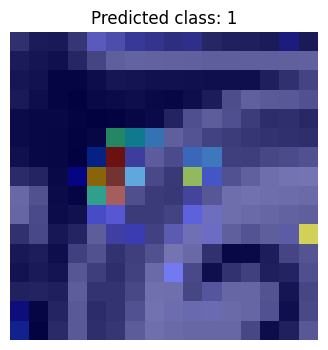

In [6]:
# Pick a sample
idx = np.random.randint(len(x_test))
img = x_test[idx:idx+1].astype(np.float32)  # shape (1,32,32,1)

# Define a forward function to get conv2d_23 output and final output
conv_layer_name = "conv2d_23"
conv_output = None
def forward(x):
    global conv_output
    for layer in custom_model.layers:
        x = layer(x)
        if layer.name == conv_layer_name:
            conv_output = x
    return x

# Compute prediction and gradients
img_tensor = tf.convert_to_tensor(img)
with tf.GradientTape() as tape:
    tape.watch(img_tensor)
    predictions = forward(img_tensor)
    class_index = tf.argmax(predictions[0])
    loss = predictions[:, class_index]

# Gradients of the loss w.r.t conv layer
grads = tape.gradient(loss, conv_output)

# Global average pooling
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))

# Weight conv outputs
conv_output = conv_output[0]
heatmap = conv_output @ pooled_grads[..., tf.newaxis]
heatmap = tf.squeeze(heatmap)

# Normalize heatmap
heatmap = np.maximum(heatmap, 0)
heatmap /= (np.max(heatmap) + 1e-8)

# Plot
plt.figure(figsize=(4,4))
plt.imshow(np.squeeze(img), cmap='gray')
plt.imshow(heatmap, cmap='jet', alpha=0.5)
plt.axis('off')
plt.title(f"Predicted class: {class_index.numpy()}")
plt.show()
